In [1]:
pip install opencv-python 

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install torch

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install torchvision

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install opencv-python matplotlib scikit-image numpy

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install scikit-image matplotlib numpy

Note: you may need to restart the kernel to use updated packages.


In [6]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2

from skimage.feature import graycoprops, graycomatrix
from skimage.io import imread
from skimage.transform import resize
from skimage.feature import hog
from skimage import exposure
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import seaborn as sns

from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix

import torch
from torchvision import models
import torchvision.transforms as transforms

# Preprocessing

In [8]:
def load_images(dir_name):

    img_list = []

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))

    for item in os.listdir(dir_name):

        img_path = os.path.join(dir_name, item)
        #print(img_path)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        img = cv2.GaussianBlur(img, (5,5), 1)

        img = clahe.apply(img)
        
        img_list.append(img)

    
    return img_list
 
def img_to_array(img):
    
    
    img = np.asarray(img)
    return img
  
def find_edges(img_list):

    for i, img in enumerate(img_list):
        
        v = np.median(img)
        sigma = 0.33

        lower = int(max(0, (1.0 - sigma) * v))
        upper = int(max(0, (1.0 + sigma) * v))

        img = cv2.Canny(img, lower, upper)
        
        img_list[i] = img

    
    return img_list

def find_edge(img):
    v = np.median(img)
    sigma = 0.33

    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(max(0, (1.0 + sigma) * v))

    img = cv2.Canny(img, lower, upper)
    
    return img

def get_features(image_list):

    feature_list = []

    distances = [1,3,5,9]
    angles = [0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi, 5*np.pi/4, 3*np.pi/2]

    properties = ['energy', 'correlation', 'dissimilarity', 'homogeneity', 'contrast']

    # need to add more distances (1,3,5,9)
    for n, img in enumerate(image_list):
        glcm = graycomatrix(img, distances, angles , levels=256, normed=True)
        feature_row = {}

        for prop in properties:
            prop_values = graycoprops(glcm, prop)   
            for i, dist in enumerate(distances):
                for j, angle in enumerate(angles): 
                    feature_name = f"{prop}_d{dist}_a{int(np.degrees(angle))}"
                    feature_row[feature_name] = prop_values[i, j]

        feature_list.append(feature_row)
    return feature_list

def view_corr(df):
    corr_matrix = df.corr()
    sns.heatmap(corr_matrix)
    plt.show()

def pca_df_pick_comp(df):

    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(df)

    pca = PCA()
    pca_features = pca.fit_transform(scaled_features)

    pca_df = pd.DataFrame(pca_features, columns=[f"PC{i+1}" for i in range(pca.n_components_)])

    pca_tot = pca_df
    plt.plot(range(1,len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_.cumsum())
    plt.xlabel("Num of components")
    plt.ylabel('Cumulative exlpained by variance')
    plt.title('explained variance by pca components')
    plt.show()

    cumulative_var = pca.explained_variance_ratio_.cumsum()
    n_components = 0

    for i, var in enumerate(cumulative_var):
        if var >= 0.95:
            n_components = i + 1
            break

    pca = PCA(n_components=n_components)
    reduced_features = pca.fit_transform(scaled_features)

    pca_columns = [f"PC{i+1}" for i in range(n_components)]
    pca_df= pd.DataFrame(reduced_features, columns=pca_columns)

    return pca_df, pca_tot

# HOG Feature

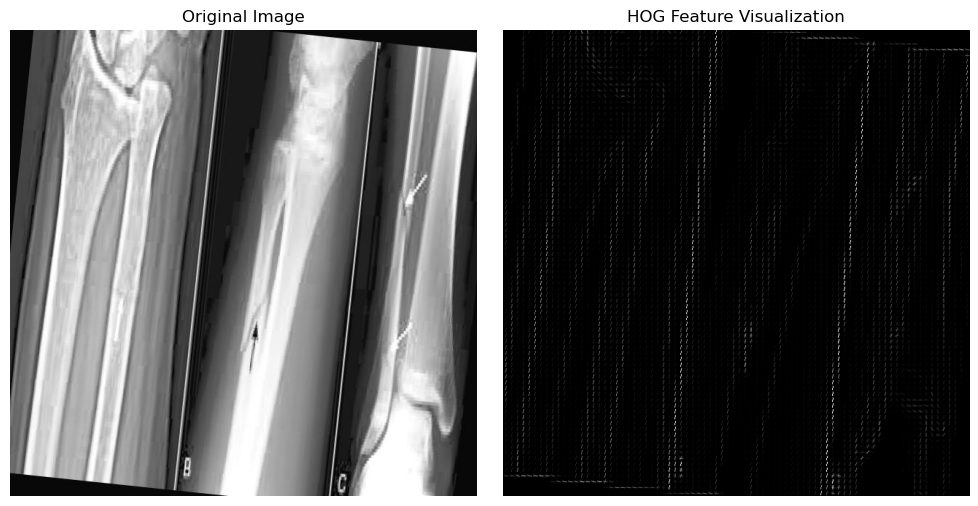

Total images processed for set 1: 316
Shape of first HOG feature vector for set 1: (224676,)


In [10]:
def extract_hog_features(image_path):
    # Read the image
    image = cv2.imread(image_path)
    
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Compute HOG features with visualization
    fd, hog_image = hog(gray, 
                        orientations=9, 
                        pixels_per_cell=(8, 8), 
                        cells_per_block=(2, 2), 
                        visualize=True)
    
    return fd, hog_image

def load_images(directory):
    image_paths = []
    for filename in os.listdir(directory):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tif', '.tiff')):
            full_path = os.path.join(directory, filename)
            image_paths.append(full_path)
    return image_paths

# Load images from different directories
image_list_1 = load_images("./data_xray/Impacted fracture")
image_list_2 = load_images("./data_xray/Intra-articular fracture")
image_list_3 = load_images("./data_xray/Longitudinal fracture")
image_list_4 = load_images("./data_xray/Oblique fracture")

# Extract HOG features for each list
hog_features_1 = [extract_hog_features(path)[0] for path in image_list_1]
hog_features_2 = [extract_hog_features(path)[0] for path in image_list_2]
hog_features_3 = [extract_hog_features(path)[0] for path in image_list_3]
hog_features_4 = [extract_hog_features(path)[0] for path in image_list_4]

# Visualization of HOG features for the first image set
if image_list_1:
    plt.figure(figsize=(10, 5))
    
    # Original image
    original_image = cv2.imread(image_list_1[0])
    original_image_rgb = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(original_image_rgb)
    plt.axis('off')
    
    # HOG visualization
    _, hog_image = extract_hog_features(image_list_1[0])
    plt.subplot(1, 2, 2)
    plt.title("HOG Feature Visualization")
    plt.imshow(hog_image, cmap='gray')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

print(f"Total images processed for set 1: {len(image_list_1)}")
print(f"Shape of first HOG feature vector for set 1: {hog_features_1[0].shape}")

# Edge Detection

In [12]:
def perform_edge_detection(image_paths, num_to_display=5):
    for i, image_path in enumerate(image_paths[:num_to_display]):
        try:
            # Read the image in grayscale
            image = imread(image_path, as_gray=True)
            
            # Calculate edges
            edges_horizontal = prewitt_h(image)
            edges_vertical = prewitt_v(image)
            
            # Display results
            plt.figure(figsize=(15, 5))
            
            plt.subplot(1, 3, 1)
            plt.title("Original Image")
            plt.imshow(image, cmap='gray')
            plt.axis('off')
            
            plt.subplot(1, 3, 2)
            plt.title("Horizontal Edges")
            plt.imshow(edges_horizontal, cmap='gray')
            plt.axis('off')
            
            plt.subplot(1, 3, 3)
            plt.title("Vertical Edges")
            plt.imshow(edges_vertical, cmap='gray')
            plt.axis('off')
            
            plt.tight_layout()
            plt.show()
        
        except Exception as e:
            print(f"Error processing {image_path}: {e}")

perform_edge_detection(image_list_1)

Error processing ./data_xray/Impacted fracture/images27_jpg.rf.6aa92d801a2b8f4da1a83085d27da27b.jpg: name 'prewitt_h' is not defined
Error processing ./data_xray/Impacted fracture/Collesfracture_jpg.rf.1d32b4c03f39d73a2664f4d3a042f429.jpg: name 'prewitt_h' is not defined
Error processing ./data_xray/Impacted fracture/image16_jpeg.rf.50b13e5122d3bfcf02484935121b5054.jpg: name 'prewitt_h' is not defined
Error processing ./data_xray/Impacted fracture/image29_jpeg.rf.cd5ed5b8d2f0690fda8bbe86b9761919.jpg: name 'prewitt_h' is not defined
Error processing ./data_xray/Impacted fracture/images25_jpg.rf.23cb85cafcf2a1b359d769dbffb72680.jpg: name 'prewitt_h' is not defined
